In [1]:
# import ipyparallel as ipp
from mpi4py import MPI
"""
def mpi_example(comm):
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"

def get_comm():
    return MPI.COMM_WORLD
cluster = ipp.Cluster(engines='mpi', n=4, launcher='mpiexec')

rc = cluster.start_and_connect_sync()
rc.activate()
view = rc.broadcast_view()

comms = view.apply_sync(get_comm)
"""

'\ndef mpi_example(comm):\n    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"\n\ndef get_comm():\n    return MPI.COMM_WORLD\ncluster = ipp.Cluster(engines=\'mpi\', n=4, launcher=\'mpiexec\')\n\nrc = cluster.start_and_connect_sync()\nrc.activate()\nview = rc.broadcast_view()\n\ncomms = view.apply_sync(get_comm)\n'

In [7]:
# calculation imports
from mpi4py import MPI
from petsc4py import PETSc

# plotting
import matplotlib.pyplot as plt
import pyvista

# dolfinx and meshing
import numpy as np
import gmsh
from dolfinx import geometry
from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical, locate_dofs_topological
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter, gmshio, XDMFFile
from dolfinx.mesh import create_unit_square,create_rectangle, CellType, meshtags, locate_entities_boundary
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym,
                 SpatialCoordinate, conditional, ge, le)

# saving results
import dtoolcore
import dtoolcore.utils as utils
import time
import numpy as np
import json

In [8]:
def create_obst(comm,H=1, L=3,r=.3, Ox=1.5, lc=.07):
    #create_obst(MPI.COMM_WORLD,height, length, r, Ox, tol)
    model_rank = 0
    infl, outfl, upper, lower = [],[],[],[]
    if comm.rank == model_rank:
        gmsh.initialize()
        gmsh.model.add("canal")
        
        cm = 1 # e-02 # not needed for our sim
        h1 = H * cm
        l1 = L * cm
        r = r * cm
        Lc1 = lc
        
        # We start by defining some points and some lines. To make the code shorter we
        # can redefine a namespace:
        factory = gmsh.model.geo
        model = gmsh.model
        
        factory.addPoint(0, 0, 0, Lc1, 1)
        factory.addPoint(l1, 0, 0, Lc1, 2)
        factory.addPoint(l1, h1 , 0, Lc1, 3)
        factory.addPoint(0, h1, 0, Lc1, 4)
        
        factory.addPoint(Ox-r, h1, 0, Lc1, 5)
        factory.addPoint(Ox, h1, 0, Lc1, 6)
        factory.addPoint(Ox+r, h1, 0, Lc1, 7)
        
        factory.addLine(1, 2, 8)
        factory.addLine(2, 3, 9)
        factory.addLine(3, 7, 10)
        factory.addLine(5, 4, 11)
        factory.addLine(4, 1, 12)
        
        factory.addCircleArc(5, 6, 7, 13)
        
        # Define the inner curve loop (the circle arc)
        factory.addCurveLoop([-13], 14)
        
        # Define the outer curve loop
        factory.addCurveLoop([8, 9, 10, -13, 11, 12], 15)
        
        # Create the plane surface with a hole
        factory.addPlaneSurface([15], 16)
        factory.synchronize()
        
        upper = model.addPhysicalGroup(1, [10, -13, 11])
        model.setPhysicalName(1, upper, "upper_wall")
        outfl = model.addPhysicalGroup(1, [9])
        model.setPhysicalName(1, outfl, "outflow")
        infl = model.addPhysicalGroup(1, [12])
        model.setPhysicalName(1, infl, "inflow")
        lower = model.addPhysicalGroup(1, [8])
        model.setPhysicalName(1, lower, "lower_wall")

        gmsh.model.addPhysicalGroup(2, [16], tag=5, name="Domain")
        factory.synchronize()
        gmsh.model.mesh.generate(2)
    infl = comm.bcast(infl, root=0)
    outfl = comm.bcast(outfl, root=0)
    upper = comm.bcast(upper, root=0)
    lower = comm.bcast(lower, root=0)
    gmsh.model = comm.bcast(gmsh.model, root=0)
    print("<< meshing in gmshio >> \n comm_rank is:", comm.rank)
    mesh, ct, ft = gmshio.model_to_mesh(gmsh.model, comm, model_rank,gdim=2)
    print("<< returning mesh >>")
    return mesh, ct, ft, infl, outfl, upper, lower



In [9]:
#run_sim(height=1,length=10,pres=6,T=3,num_steps=1000,r=.3,file=False,run=2, tol=0.07)

In [10]:
# Get mass flow and pressure
def mfl_press(x_max, mesh, u_n, p):
    # Extract the normal component of velocity (u_x in 2D)
    u_sub = u_n.sub(0)

    # Define measures and spatial coordinates
    dx = Measure("dx", domain=mesh)
    x = SpatialCoordinate(mesh)
    pos = np.linspace(0+.5,x_max-.5,30)
    mass_flow, pressure_avg = np.array([]), np.array([])
    for i in pos:
        slice_condition = conditional(ge(x[0], i-2e-1), 1.0, 0.0) * conditional(le(x[0], i+2e-1), 1.0, 0.0)
        # Calculate mass flow rate at the current slice
        mf = assemble_scalar(form(u_sub * slice_condition * dx))
        mass_flow = np.append(mass_flow,mf)
        # Calculate average pressure at the current slice
        pa = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx) )
        pressure_avg = np.append(pressure_avg, pa)
    return mass_flow, pressure_avg

def write_x_parview(msh,ct,ft, name):
    with XDMFFile(msh.comm, f"out_gmsh/mesh_rank_{MPI.COMM_WORLD.rank}.xdmf", "w") as file:
        #msh.topology.create_connectivity(1, 2)
        file.write_mesh(msh)
        file.write_meshtags(ct, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{name}_ct']/Geometry")
        file.write_meshtags(ft, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{name}_ft']/Geometry")

def plot_para_velo(ax, mesh, u_n, p_n, t, length, pres, Ox, r, tol):
    if MPI.COMM_WORLD.rank == 0:
        #fig, ax = plt.subplots()
        #plt.xlabel('y')
        #plt.ylabel('u_n')
        #plt.title('u_n values at different x-coordinates')
        y = np.linspace(0+tol, length, int(length/tol))
        points = np.zeros((3, int(length/tol)))
        points[1] = y
        points[0] = 0
        
        bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
        cells, cells1, cells2, p_o_p, p_o_p1, p_o_p2 = [], [], [], [], [], []

        def get_points_of_cells(bb_tree, msh, point, pop, cell):
            # Find cells whose bounding-box collide with the the points
            cell_candidates = geometry.compute_collisions_points(bb_tree, point.T)
            # Choose one of the cells that contains the point
            colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, point.T)
            for i, point in enumerate(points.T):
                if len(colliding_cells.links(i)) > 0:
                    pop.append(point)
                    cell.append(colliding_cells.links(i)[0])
            pop = np.array(pop, dtype=np.float64)
            u_val = u_n.eval(pop, cell)
            p_val = p_n.eval(pop, cell)
            return pop, u_val, p_val

        # get velocity procile values at x[0] = 0
        p_o_p, u_values, p_values = get_points_of_cells(bb_tree, mesh, points, p_o_p, cells)

        # get velocity procile values at x of obstacle
        y2 = np.linspace(0+tol, length-(r+tol), int(length/tol))
        points[1] = y2
        points[0] = Ox
        p_o_p1, u_values1, p_values1 = get_points_of_cells(bb_tree, mesh, points, p_o_p1, cells1)

        # get velocity profile at end of canal
        points[1] = y
        points[0] = length
        p_o_p2, u_values2, p_values2 = get_points_of_cells(bb_tree, mesh, points, p_o_p2, cells2)
        
        ax.set_title("Velocity over x-Axis")
        ax.plot(p_o_p[:, 1], u_values[:,0], "k", linewidth=2, label="x=0")
        ax.plot(p_o_p1[:, 1], u_values1[:,0], "y", linewidth=2, label=r"x=%s"%(Ox))
        ax.plot(p_o_p2[:, 1], u_values2[:,0], "b", linewidth=2, label=r"x=%s"%(length))
        ax.legend()
        ax.set_xlabel("x")
        ax.set_ylabel("Velocity u")
        # If run in parallel as a python file, we save a plot per processor
        plt.savefig(f"para_plot/u_n_p_{int(r):d}_{int(pres):d}_{int(t*100):d}.pdf") #25_{int(pres):d}_{int(t*100):d}.pdf")
        return p_o_p[:, 1], u_values[:,0], p_o_p1[:, 1], u_values1[:,0], p_o_p2[:, 1], u_values2[:,0]

def plot_2dmesh(V, mesh, u_n, c):
    #pyvista.start_xvfb()
    topology, cell_types, geo = vtk_mesh(V)
    values = np.zeros((geo.shape[0], 3), dtype=np.float64)
    values[:, :len(u_n)] = u_n.x.array.real.reshape((geo.shape[0], len(u_n)))
    
    # Create a point cloud of glyphs
    function_grid = pyvista.UnstructuredGrid(topology, cell_types, geo)
    function_grid["u"] = values
    glyphs = function_grid.glyph(orient="u", factor=0.2)
    
    # Create a pyvista-grid for the mesh
    grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))
    
    # Create plotter
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, style="wireframe", color="k")
    plotter.add_mesh(glyphs)
    plotter.view_xy()
    if not pyvista.OFF_SCREEN:
        plotter.show()
        plotter.screenshot(f"canal_{c:d}.png")
    else:
        #f"para_plot/u_n_p_canal_test")#{int(pres):d}
        fig_as_array = plotter.screenshot(f"glyphs_{c:d}.png")

In [11]:
def store_array(arr, name, path, p, db="dtool_db", t=-1):
    
    if arr.size > 0:
        fpath = path+"/data/"
        if t!= -1:
            fpath = path+"/data/"+name+str(t)+"/"
        utils.mkdir_parents(fpath)
        np.savetxt(fpath+name+".txt", arr, fmt='%.10e')
        #p.put
    print(f"Dataset '{name:s}' saved at {fpath:s}")

def init_db(dataset_name, identifier=True, db="dtool_db"):
    """
    Initialize a new dtool dataset.

    This function creates a new proto dataset using dtoolcore. It generates a unique
    database path based on the current epoch time and the provided dataset name.

    Args:
        dataset_name (str): The name of the dataset to be created.
        db (str, optional): The base directory for the database. Defaults to "dtool_db".

    Returns:
        tuple: A tuple containing two elements:
            - proto (dtoolcore.ProtoDataSet): The created proto dataset object.
            - db_path (str): The full path to the created database.

    Example:
        >>> proto, db_path = init_db("my_dataset")
        >>> print(db_path)
        dtool_db/my_dataset_1636456789.123456
    """
    epoch = time.time()
    db_path = db+"/"+dataset_name+"_"+str(epoch)
    if not identifier:
        db_path = db
    utils.mkdir_parents(db_path+"/")
    print(f"Dataset '{db_path:s}' lala")
    proto = dtoolcore.create_proto_dataset(dataset_name,
                db_path,
                readme_content=f"canal_data_{dataset_name:s}",
                creator_username="Ilia Fedotov")
    return proto, db_path+"/"+dataset_name

def write_values_to_json(values, names):
    """
    Write a list of values and corresponding names into a JSON variable.

    Args:
        values (list): A list of values to be written (should be numbers).
        names (list): A list of names corresponding to the values.

    Returns:
        data (json): A json list for dtool annotations

    Example:
        >>> write_values_to_json([1.5, 2.7, 3.2], ['a', 'b', 'c'])
        # This will create a file 'output.json' with the content:
        # [{"a": 1.5, "b": 2.7, "c": 3.2}]
    """
    # Check if the lengths of values and names match
    if len(values) != len(names):
        raise ValueError("The number of values must match the number of names")

    # Check if all values are numbers
    if not all(isinstance(v, (int, float)) for v in values):
        raise TypeError("All values must be numbers (integers or floats)")

    # Create the data structure
    data = [{name: value for name, value in zip(names, values)}]
    return data


#s = np.linspace(1,11,10000)
#s
#p, pat = init_db("test", False)
#store_array(s, "teststring", pat, p)
#store_array(s, "teststring2", pat)
#store_array(s, "teststring3", pat)
#p.put_annotation("metadata", write_values_to_json([1,2,3],["pressure_diff", "time", "timestep"]))
#p.freeze()

In [12]:
def run_sim(height=1, length=3,pres=8,T=.5,num_steps=500,r=0, file=False, run=1, tol=.07):
    Ox = length/2
    if run==0:
        mesh = create_rectangle(MPI.COMM_WORLD,[[0,0], [length, height]],[int(length*25),int(height*25)])
    if run == 1:
        mesh = create_unit_square(MPI.COMM_WORLD, 100, 100)
    if run == 2:
        # create_obst(comm,H=1, L=3,r=.3, Ox=1.5, lc=.07):
        mesh, ct, ft, inlet_marker,outlet_marker, upper_wall_marker, lower_wall_marker = create_obst(MPI.COMM_WORLD,height, length, r, Ox, tol)
    
    debug = True
    t = 0
    pres = pres * length
    dt = T / num_steps

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)

    fdim = mesh.topology.dim - 1

    #write_x_parview(mesh,ct,ft, "my_mesh")

    wall_dofs = locate_dofs_topological(V, fdim, ft.find(upper_wall_marker))
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip1 = dirichletbc(u_noslip, wall_dofs, V)

    wall_dofs = locate_dofs_topological(V, fdim, ft.find(lower_wall_marker))
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip2 = dirichletbc(u_noslip, wall_dofs, V)
    
    inflow_dofs = locate_dofs_topological(Q, fdim, ft.find(inlet_marker))
    bc_inflow = dirichletbc(PETSc.ScalarType(pres), inflow_dofs, Q)
    
    outflow_dofs = locate_dofs_topological(Q, fdim, ft.find(outlet_marker))
    bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
    bcu = [bc_noslip1, bc_noslip2]
    bcp = [bc_inflow, bc_outflow]
    if debug:
        print("<< done boundary conditions >>")
    #write_x_parview(mesh,ct,ft, "my_mesh")

    # gmsh.clear()
    
    u_n = Function(V)
    u_n.name = "u_n"
    U = 0.5 * (u_n + u)
    n = FacetNormal(mesh)
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(1))
    rho = Constant(mesh, PETSc.ScalarType(1))
    
    # Define strain-rate tensor
    def epsilon(u):
        return sym(nabla_grad(u))
    
    # Define stress tensor
    def sigma(u, p):
        return 2 * mu * epsilon(u) - p * Identity(len(u))
    
    
    # Define the variational problem for the first step
    p_n = Function(Q)
    p_n.name = "p_n"
    F1 = rho * dot((u - u_n) / k, v) * dx
    F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
    F1 += inner(sigma(U, p_n), epsilon(v)) * dx
    F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
    F1 -= dot(f, v) * dx
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    
    
    A1 = assemble_matrix(a1, bcs=bcu)
    A1.assemble()
    b1 = create_vector(L1)
    
    # Define variational problem for step 2
    u_ = Function(V)
    a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
    L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)
    
    # Define variational problem for step 3
    p_ = Function(Q)
    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)
    
    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.HYPRE)
    pc1.setHYPREType("boomeramg")
    
    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.BCGS)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")
    
    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)
    if debug:
        print("<< formulated function and solvers >>")
    if file:
        from pathlib import Path
        folder = Path("results")
        folder.mkdir(exist_ok=True, parents=True)
        vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
        vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
        vtx_u.write(t)
        vtx_p.write(t)
    
    def u_exact(x):
        values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * x[1] * (1.0 - x[1])
        return values
    
    u_ex = Function(V)
    u_ex.interpolate(u_exact)
    
    L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

    # add a simple plot output 
    fig, ax = plt.subplots(3,1)
    plt.xlabel('y')
    plt.ylabel('u_n')
    plt.title('u_n values at different x-coordinates')
    counter = 0

    # create dtool entry for the run
    if MPI.COMM_WORLD.rank == 0:
        p, pat = init_db("canal_"+str(r)+"_"+str(T), False)
        # annotate metadata : height=1, length=3,pres=8,T=.5,num_steps=500,r=0, file=False, run=1, tol=.07):
        p.put_annotation("metadata", write_values_to_json([height, length, pres, T, num_steps, r, Ox, tol],
                                                          ["height", "length", "pressure_delta", "simulation_time", 
                                                           "steps", "radius", "obstacle_location_x","meshing_size/tol"]))
    
    if debug:
        print("<< starting loop >>")
    for i in range(num_steps):
        # Update current time step
        t += dt
        
        # Step 1: Tentative veolcity step
        with b1.localForm() as loc_1:
            loc_1.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_.x.petsc_vec)
        u_.x.scatter_forward()
    
        # Step 2: Pressure corrrection step
        with b2.localForm() as loc_2:
            loc_2.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, p_.x.petsc_vec)
        p_.x.scatter_forward()
    
        # Step 3: Velocity correction step
        with b3.localForm() as loc_3:
            loc_3.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()
        # Update variable with solution form this time step
        u_n.x.array[:] = u_.x.array[:]
        p_n.x.array[:] = p_.x.array[:]
    
        # print velocity profile"""(i!=0) and (i % int(num_steps/5) == 0) or"""
        if (i == num_steps - 1) and MPI.COMM_WORLD.rank == 0:
            f"Hello World from rank {MPI.COMM_WORLD.Get_rank()}. total ranks={MPI.COMM_WORLD.Get_size()}"
            mfl, pa = mfl_press(length, mesh, u_n, p_n)
            x1, y1, x2, y2, x3, y3 = plot_para_velo(ax[0],mesh, u_n, p_n, t, length, pres,Ox, r, tol)
            ax[1].plot(mfl)
            ax[2].plot(pa)
            store_array(mfl, "massflowrate", pat,p)
            store_array(pa, "pressure_avg", pat,p)           
            store_array(x1, "x_at_0", pat,p)
            store_array(y1, "y_at_0", pat,p)
            store_array(x2, "x_at_.5", pat,p)
            store_array(y2, "y_at_.5", pat,p)
            store_array(x3, "x_at_1", pat,p)
            store_array(y3, "y_at_1", pat,p)
            #plot_2dmesh(V, mesh, u_n, c=counter)
            #counter+=1

        if file:
            # Write solutions to fileV
            vtx_u.write(t)
            vtx_p.write(t)
    
        # Compute error at current time-step
        error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
        error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
        # Print error only every 20th step and at the last step
        if (i % 20 == 0) or (i == num_steps - 1):
            print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
    # Close xmdf file
    p.freeze()
    if file:
        vtx_u.close()
        vtx_p.close()
    b1.destroy()
    b2.destroy()
    b3.destroy()
    solver1.destroy()
    solver2.destroy()
    solver3.destroy()
    return u_n, p_n, V, mesh

In [ ]:
#res.shape
if __name__ == '__main__':
    #run_sim(height=1,length=10,pres=8,T=3,num_steps=1000,r=.5,file=False,run=2, tol=0.05)
    for i in np.linspace(0.05,0.5,19):
        run_sim(height=1,length=10,pres=8,T=3,num_steps=1000,r=i,file=False,run=2, tol=0.04)
    #run_sim(height=1,length=10,pres=6,T=3,num_steps=1000,r=.3,file=False,run=2, tol=0.07)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 90%] Meshing curve 13 (Circle)
Info    : Done meshing 1D (Wall 0.000689762s, CPU 0.000508s)
Info    : Meshing 2D...
Info    : Meshing surface 16 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.143796s, CPU 0.135594s)
Info    : 7587 nodes 15177 elements
<< meshing in gmshio >> 
 comm_rank is: 0
<< returning mesh >>
<< done boundary conditions >>
<< formulated function and solvers >>
Dataset 'dtool_db' lala
<< starting loop >>
Time 0.00, L2-error 2.24e+00, Max error 2.61e-02
Time 0.06, L2-error 1.26e+00, Max error 1.06e-01
Time 0.12, L2-error 7.41e-01, Max error 1.50e-01
Time 0.18, L2-error 4.70e-01, Max error 1.73e-01
Time 0.24, L2-error 3.33e-01, Max error 1.86e-01
Time 0.30, L2-error 2.68e-01, Max error 1.93e-01
Time 0.36, L2-error 2.38e-

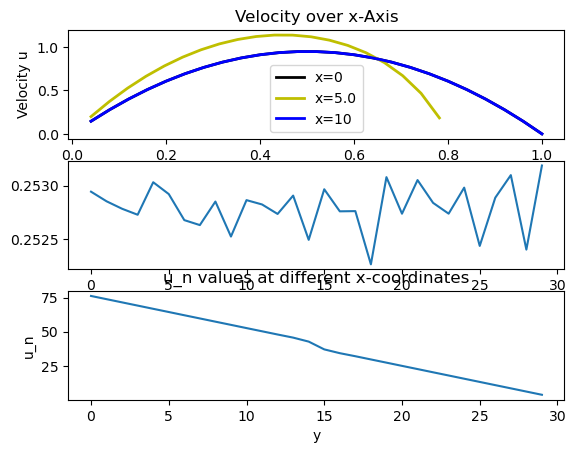

In [13]:
u, p, v, mesh = run_sim(height=1,length=10,pres=8,T=3,num_steps=1000,r=.2,file=False,run=2, tol=0.04)

In [14]:
def mfl_press(x_max, mesh, u_n, p):
    # Extract the normal component of velocity (u_x in 2D)
    u_sub = u_n.sub(0)

    # Define measures and spatial coordinates
    dx = Measure("dx", domain=mesh)
    x = SpatialCoordinate(mesh)
    pos = np.linspace(0+.5,x_max-.5,30)
    mass_flow, pressure_avg = np.array([]), np.array([])
    for i in pos:
        slice_condition = conditional(ge(x[0], i-2e-1), 1.0, 0.0) * conditional(le(x[0], i+2e-1), 1.0, 0.0)
        # Calculate mass flow rate at the current slice
        mf = assemble_scalar(form(u_sub * slice_condition * dx))
        mass_flow = np.append(mass_flow,mf)
        # Calculate average pressure at the current slice
        pa = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx) )
        pressure_avg = np.append(pressure_avg, pa)
    return mass_flow, pressure_avg
mfl, pre = mfl_press(10,mesh,u, p)

In [ ]:
"""
# Example usage
s = np.arange(0,100,.33)
epoch = time.time()
res = np.array( [[s,s],[s,s],[s,s]] )
t = np.array([1,2,3])

store_xy_arrays(xy,t, "sine_wave", "dtool_db")

# %% jupyter={"source_hidden": true}
s = np.arange(0,100,.33)
epoch = time.time()
res = np.array( [[s,s],[s,s],[s,s]] )
t = np.array([1,2,3])

def save_numpy_array(array, file_path):
    np.savetxt(file_path, array, fmt='%.10e')
    # dataset.put_item(file_path, name)

dataset = dtoolcore.create_proto_dataset("run_" + str(epoch), "dtool_db")

#{"description": "Raw data files for plots"})
#ds_creator.put_annotation(folders[0], {"description": "Source for x, y coordinates of different "})
# {"description": "Fedotov Ilia - bsc data, dolfinx results"})
#utils.mkdir_parents("dtool_db/run"+str(epoch)+"/"+folders[0] )
count = 0
for x,y in res:
    utils.mkdir_parents("dtool_db/run_"+str(epoch)+"/data/"+str(t[0])+"/" )
    for x,y in res:
        save_numpy_array(x,"dtool_db/run_"+str(epoch)+"/data/"+str(t[0])+"/x.txt")
        save_numpy_array(y,"dtool_db/run_"+str(epoch)+"/data/"+str(t[0])+"/y.txt")
        count+=1

# code for stacking xy:
s = np.array([ [1,2,3],[4,5,6] ])
t = np.stack([s, s])
t = np.concatenate([t, np.expand_dims(s, axis=0)], axis=0)
t = np.concatenate([t, np.expand_dims(s, axis=0)], axis=0)
t

"""